## What is needed?

Using native code, we want to:

- Create Gamma with new scaling
- Sample `zs` and compare to previous version (in frequency and time domain)
- Samples point process observations and compare to previous version (time domain)
- Check sampling distribution variance for naive / oracle 
- Pick oscillation / mu and look at sampling distribution of model estimate 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import glob as glob

import hydra
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.observations import sample_obs
from cohlib.utils import add0, jax_boilerplate, pickle_save, pickle_open

import cohlib.confs.utils as conf
from cohlib.confs.latent import create_lrccn_basic_rank1
from cohlib.confs.config import get_sim_config

In [3]:
# Get plots for previously saved data with large oscillations / high rate

In [5]:
def mod_config(cfg, scale_power, K, L, theta):
    cfg.latent.L = L
    cfg.latent.scale_power_target = scale_power
    cfg.latent.K = K
    if cfg.obs.obs_type == 'gaussian':
        cfg.obs.ov2 = theta
    elif cfg.obs.obs_type in ['pp_relu', 'pp_log']:
        cfg.obs.mu = theta
    else:
        raise ValueError

    return cfg

def get_plot_dict(func, cfg, scale_power, K, L, theta, seeds):
    cfg = mod_config(cfg, scale_power, K, L, theta)
    plot_data = {}
    plot_data['true'] = []
    plot_data['oracle'] = []
    plot_data['model'] = []
    plot_data['naive'] = []
    for s, seed_use in enumerate(seeds):
        true, oracle, model, naive = func(cfg, seed_use)
        plot_data['true'].append(true) 
        plot_data['oracle'].append(oracle)
        plot_data['model'].append(model)
        plot_data['naive'].append(naive)

    return plot_data

In [6]:
def naive_estimator_logmod(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

def eigval1_logmod(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigval_true = lrccn_true.eigvals[0,eigrank-1]

    eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*np.log(1e6)
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_true, eigval_oracle, eigval_model, eigval_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [7]:
from cohlib.utils import naive_estimator
from cohlib.plot import get_eigval

def get_theta_label(ocfg, theta):
    if ocfg.obs_type == 'gaussian':
        label = f'{ocfg.ov1}e{theta}'
    elif ocfg.obs_type in ['pp_relu', 'pp_log']:
        label = f'mu = {theta}'
    else:
        return ValueError
    return label

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

def eigval1(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigval_true = lrccn_true.eigvals[0,eigrank-1]

    eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_true, eigval_oracle, eigval_model, eigval_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [8]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

In [9]:
from cohlib.plot import get_eigvec
from cohlib.utils import rotate_eigvecs
def eigvec1(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]

    eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvec_oracle = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
    eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sampling_dists(ax, data_matrix, category_labels, jitter=False, jitter_strength=0.05, colors=None):
    """
    Plot data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array or matrix of shape (N, C), with N data points per each of the C categories.
    - category_labels: List of category labels (length C).
    - jitter: Boolean indicating whether to jitter points along the x-axis.
    - jitter_strength: Magnitude of jitter applied along x-axis.
    """
    N, C = data_matrix.shape
    x_positions = np.arange(C)

    if colors is None:
        colors = ['tab:red', 'tab:blue', 'tab:green']


    for i in range(C):
        y = data_matrix[:, i]
        x = np.full(N, x_positions[i], dtype=float)

        if jitter:
            x += np.random.uniform(-jitter_strength, jitter_strength, size=N)

        ax.scatter(x, y, alpha=0.7, color=colors[i])
        # ax.scatter(x, y, alpha=0.7, edgecolors='k', color=colors[i])

    ax.set_xticks(x_positions, category_labels)
    plt.tight_layout()

K=3 - num nans = 0
K=10 - num nans = 0
K=25 - num nans = 0


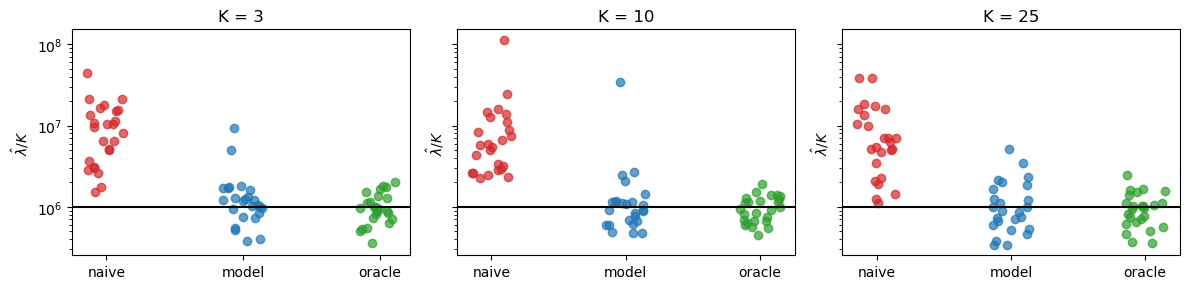

In [11]:
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

nseeds = 25
m=0
seeds = [x + nseeds*m for x in range(nseeds)]
nseeds = 25
m=0
seeds = [x + nseeds*m for x in range(nseeds)]
L = 5
# mu = -0.8
mu = 0.1
# mu = 0.8
# mu = 1.5
# mu = 2.4

Ks = [3, 10, 25]

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

scale_power = int(1e6)

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

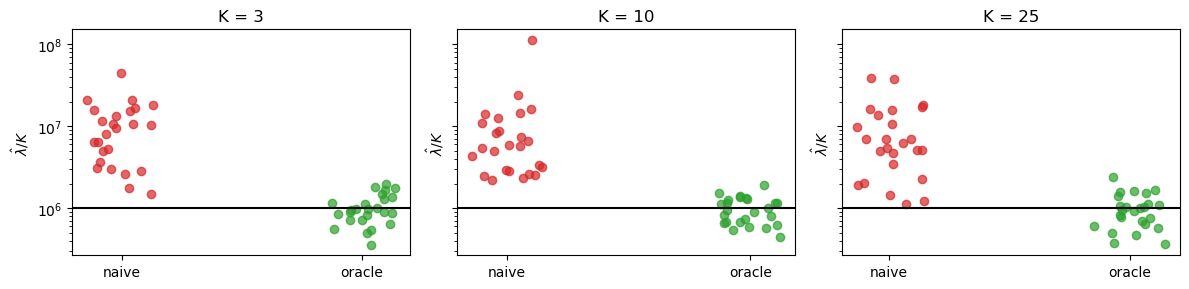

In [24]:
Ks = [3, 10, 25]

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

L = 5
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    category_labels = ['naive', 'oracle']

    colors = ['tab:red', 'tab:green']
    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15, colors=colors)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

In [14]:
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(1e4)
mu = 2.3
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K20/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


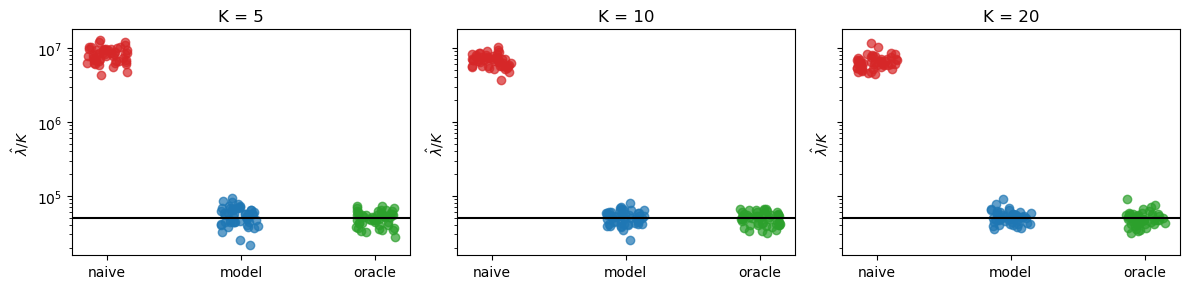

In [17]:
nseeds = 50
m=0
seeds = [x + nseeds*m for x in range(nseeds)]

L = 25

Ks = [5, 10, 20]

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

K=10 - num nans = 0
K=10 - num nans = 0


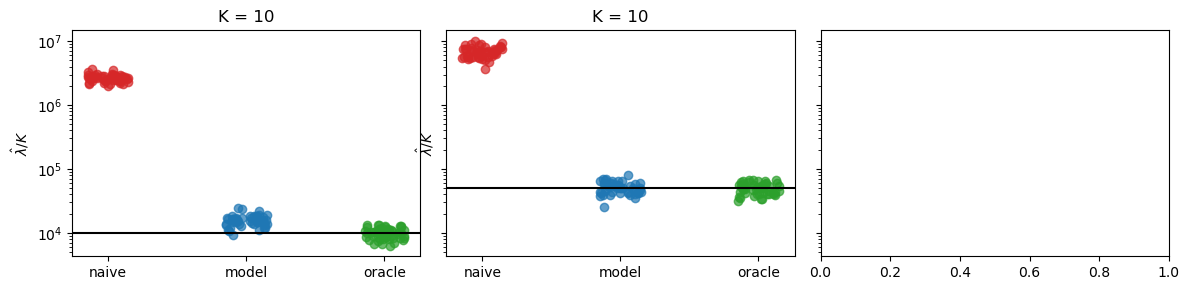

In [18]:
nseeds = 50
m=0
seeds = [x + nseeds*m for x in range(nseeds)]

L = 25

K = 10

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

sps = [int(1e4), int(5e4)]

for i, scale_power in enumerate(sps):
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

In [24]:
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)
naive_list = []
model_list = []
oracle_list = []
for K in Ks:
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive'])/K)
    oracle_list.append(jnp.array(plot_dict['oracle'])/K)
    model_list.append(jnp.array(plot_dict['model'])/K)

Text(0.5, 1.0, 'Naive')

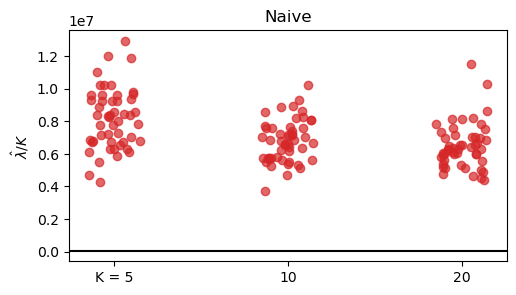

In [25]:
data = jnp.vstack(naive_list).T
category_labels = ['K = 5', '10', '20']
colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(5,3))
plot_sampling_dists(ax, data, category_labels, jitter=True, jitter_strength=0.15, colors=colors)
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'Naive')
# ax.set_yscale('log')

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sampling_dists_violin(ax, data_matrix, category_labels, alpha=0.5, violin_colors=None):
    """
    Plot data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array or matrix of shape (N, C), with N data points per each of the C categories.
    - category_labels: List of category labels (length C).
    """
    N, C = data_matrix.shape
    x_positions = np.arange(C)

    if violin_colors is None:
        violin_colors = ['tab:blue' for x in range(C)]
    elif type(violin_colors) is str:
        violin_colors_temp = [violin_colors for x in range(C)]
        violin_colors = violin_colors_temp
    elif type(violin_colors) is list:
        assert len(violin_colors) == C

    violins = ax.violinplot(data_matrix, positions=np.arange(C), showmeans=True)

    # Set colors individually
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(alpha)
        pc.set_edgecolor('k')
        pc.set_linewidth(1)

    # Customize lines (mean, min-max)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

    # ax.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)

    ax.set_xticks(x_positions, category_labels)
    plt.tight_layout()

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


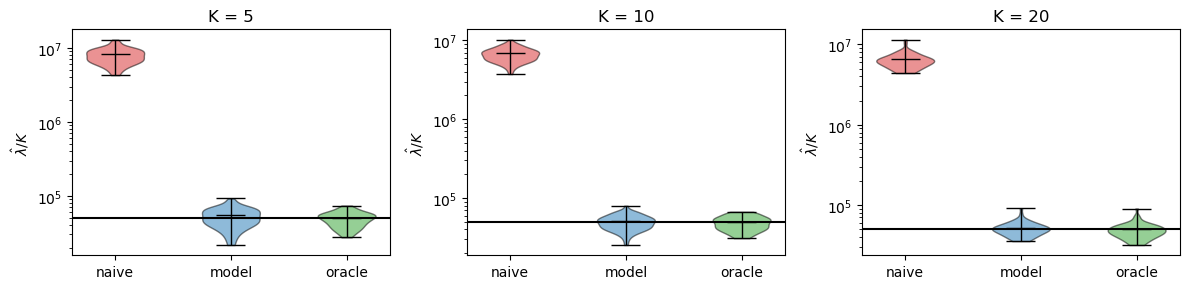

In [23]:
fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3))

# sps = [int(1e4), int(5e4)]
# scale_power = int(5e4)
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, scale_power, K, L, mu, seeds)
    data = np.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists_violin(ax[i], data, category_labels, violin_colors=['tab:red', 'tab:blue', 'tab:green'])
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

Text(0.5, 1.0, 'Naive; L = 25')

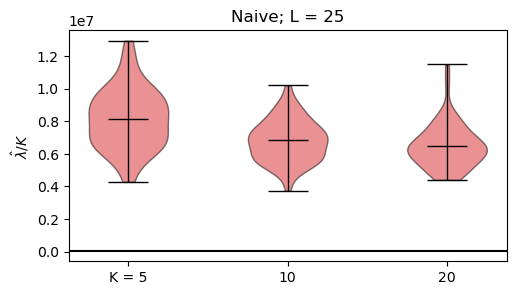

In [26]:
data = np.vstack(naive_list).T
# data = np.random.randn(50,3)
category_labels = ['K = 5', '10', '20']
# colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(5,3))
# plt.violinplot(data, positions=np.arange(len(category_labels)), showmeans=True)
plot_sampling_dists_violin(ax, data, category_labels, violin_colors='tab:red')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'Naive; L = {L}')
# # ax.set_yscale('log')

Text(0.5, 1.0, 'Model; L = 25')

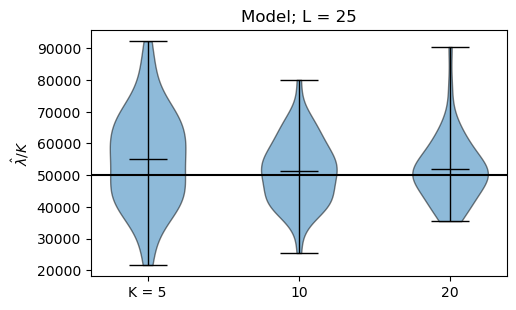

In [27]:
data = np.vstack(model_list).T
# data = np.random.randn(50,3)
category_labels = ['K = 5', '10', '20']
# colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(5,3))
# plt.violinplot(data, positions=np.arange(len(category_labels)), showmeans=True)
plot_sampling_dists_violin(ax, data, category_labels, violin_colors='tab:blue')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'Model; L = {L}')
# # ax.set_yscale('log')

Text(0.5, 1.0, 'Oracle; L = 25')

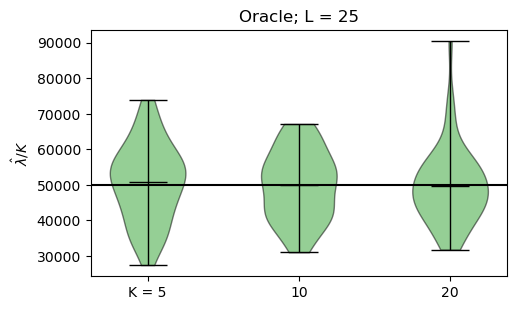

In [28]:
data = np.vstack(oracle_list).T
# data = np.random.randn(50,3)
category_labels = ['K = 5', '10', '20']
# colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(5,3))
# plt.violinplot(data, positions=np.arange(len(category_labels)), showmeans=True)
plot_sampling_dists_violin(ax, data, category_labels, violin_colors='tab:green')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'Oracle; L = {L}')
# # ax.set_yscale('log')

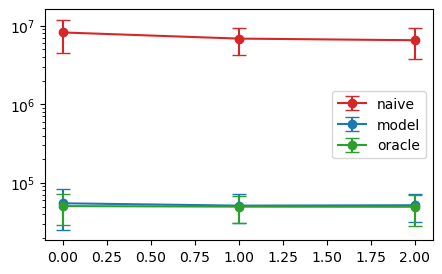

In [29]:
lists = [naive_list, model_list, oracle_list]
colors = ['tab:red', 'tab:blue', 'tab:green']
labels = ['naive', 'model', 'oracle']
fig, ax = plt.subplots(figsize=(5,3))
for i, data_list in enumerate(lists):
    data = np.vstack(data_list).T
    mean = data.mean(0)
    std = data.std(0)
    x = np.arange(3)
    ax.errorbar(x, mean, yerr=2*std, capsize=5, marker='o', color=colors[i], label=labels[i])
plt.legend()
plt.yscale('log')

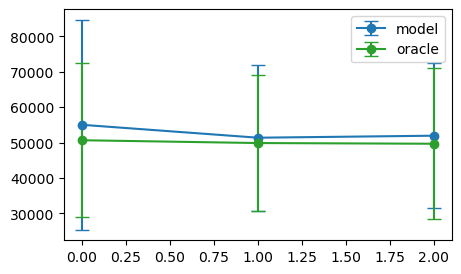

In [30]:
lists = [model_list, oracle_list]
colors = ['tab:blue', 'tab:green']
labels = ['model', 'oracle']
fig, ax = plt.subplots(figsize=(5,3))
for i, data_list in enumerate(lists):
    data = np.vstack(data_list).T
    mean = data.mean(0)
    std = data.std(0)
    x = np.arange(3)
    ax.errorbar(x, mean, yerr=2*std, capsize=5, marker='o', color=colors[i], label=labels[i])
plt.legend()
# plt.yscale('log')

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


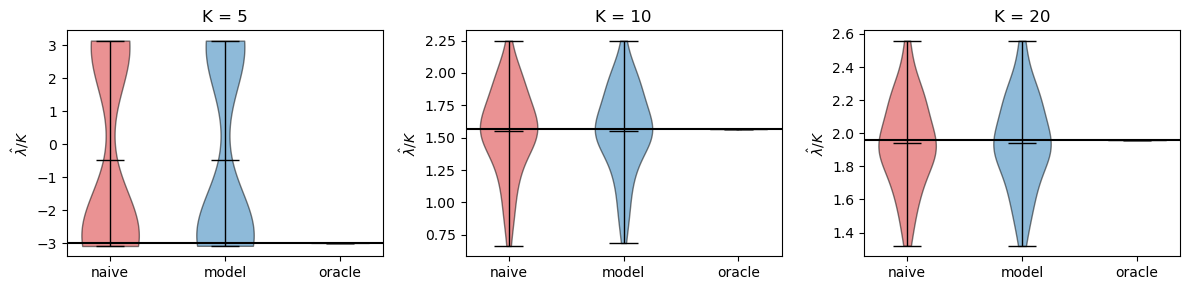

In [33]:
fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3))
func = np.angle
dim = 1

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = func(data_raw[:,:,dim])

    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists_violin(ax[i], data, category_labels, violin_colors=['tab:red', 'tab:blue', 'tab:green'])
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(func(plot_dict['true'][0][dim]), color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    # ax[i].set_ylim([-np.pi, np.pi])
    # ax[i].set_yscale('log')

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


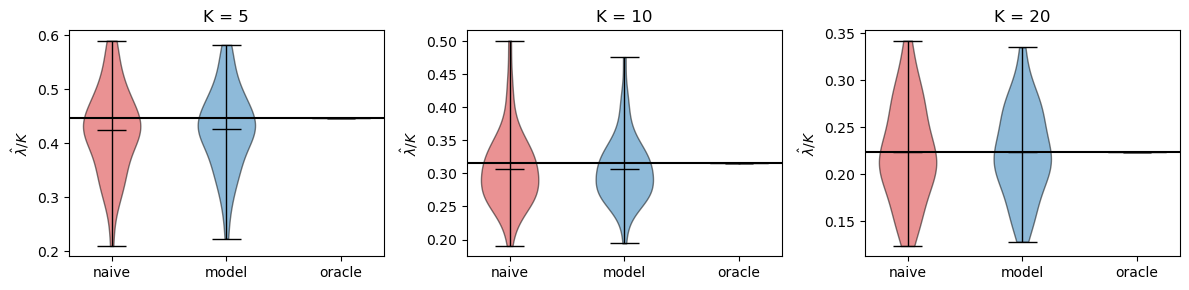

In [34]:
fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3))
func = np.abs

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = func(data_raw[:,:,dim])

    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists_violin(ax[i], data, category_labels, violin_colors=['tab:red', 'tab:blue', 'tab:green'])
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(func(plot_dict['true'][0][dim]), color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    # ax[i].set_ylim([-np.pi, np.pi])
    # ax[i].set_yscale('log')

In [35]:
plot_dict['true'][0][dim]

Array(-0.08495218+0.20684083j, dtype=complex64)

In [38]:
K = 5
plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
for dim in range(K):
    true = func(plot_dict['true'][0][dim])
    mean_naive = func(jnp.stack(plot_dict['naive'])[:,dim]).mean()
    mean_model = func(jnp.stack(plot_dict['model'])[:,dim]).mean()
    model_bias = mean_model - true
    naive_bias = mean_naive - true
    # print(f'naive bias: {naive_bias}')
    # print(f'model bias: {model_bias}')
    # print(f'bias diff (abs(naive)-abs(model)): {np.abs(naive_bias) - np.abs(model_bias)}')
    print(f'dim {dim}: {np.abs(naive_bias) - np.abs(model_bias)}')
    # print()

dim 0: 0.0035308897495269775
dim 1: 0.002431720495223999
dim 2: 0.0012249946594238281
dim 3: 5.662441253662109e-06
dim 4: 0.00043833255767822266


In [153]:
print((np.stack(naive_bias) - np.stack(model_bias)).mean())
print(np.stack(model_bias).mean())

-0.00035257562
-0.008932492


In [143]:
K = 20
plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
naive_bias = []
model_bias = []
for dim in range(K):
    true = func(plot_dict['true'][0][dim])
    std_naive = func(jnp.stack(plot_dict['naive'])[:,dim]).std()
    std_model = func(jnp.stack(plot_dict['model'])[:,dim]).std()
    # print(f'naive std: {std_naive}')
    # print(f'model std: {std_model}')
    # print(f'std diff (naive-model): {std_naive - std_model}')
    print(f'dim {dim}: {std_naive - std_model}')
    # print()

dim 0: 0.0008225962519645691
dim 1: 0.001342136412858963
dim 2: 0.0013454332947731018
dim 3: 0.0013667084276676178
dim 4: 0.0007845722138881683
dim 5: 0.0014968663454055786
dim 6: 0.001695629209280014
dim 7: 0.0009251199662685394
dim 8: 0.0015031173825263977
dim 9: 0.0007747001945972443
dim 10: 0.0012545138597488403
dim 11: 0.0011258162558078766
dim 12: 0.0008905641734600067
dim 13: 0.00156305730342865
dim 14: 0.0007822215557098389
dim 15: 0.0012408047914505005
dim 16: 0.0007881335914134979
dim 17: 0.0014048367738723755
dim 18: 0.0009481310844421387
dim 19: 0.001450568437576294


In [124]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
    print(f'Naive K={K}')
    mean = func(jnp.stack(plot_dict['naive'])[:,dim]).mean()
    std = func(jnp.stack(plot_dict['naive'])[:,dim]).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Naive K=5
mean: 0.4404281675815582
std: 0.11195862293243408
Naive K=10
mean: 0.3031008839607239
std: 0.08601284772157669
Naive K=20
mean: 0.2036525309085846
std: 0.05701557174324989


In [125]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    mean = func(jnp.stack(plot_dict['model'])[:,dim]).mean()
    std = func(jnp.stack(plot_dict['model'])[:,dim]).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Model K=5
mean: 0.4414188861846924
std: 0.10906947404146194
Model K=10
mean: 0.30404236912727356
std: 0.0845813974738121
Model K=20
mean: 0.20440532267093658
std: 0.055648863315582275


In [ ]:
plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
data = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
data.shape

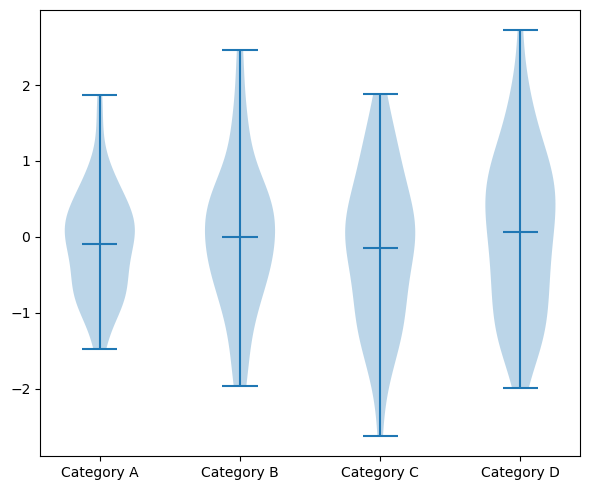

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_violin_category_matrix(data_matrix, category_labels):
    """
    Plot a violin plot of data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array of shape (N, C), with N data points per category, C categories.
    - category_labels: List of category labels (length C).
    """

    plt.figure(figsize=(max(6, len(category_labels)), 5))
    plt.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)

    plt.xticks(np.arange(len(category_labels)), category_labels)
    plt.tight_layout()
    plt.show()

# Example Usage:
np.random.seed(42)
N, C = 50, 4
category_labels = ['Category A', 'Category B', 'Category C', 'Category D']
data_matrix = np.random.randn(N, C)
plt.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)


# Plot violin plot
plot_violin_category_matrix(data_matrix, category_labels)


In [ ]:
data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K

In [87]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    print((jnp.stack(plot_dict['oracle'])/K).mean())
    print((jnp.stack(plot_dict['oracle'])/K).std())

Oracle K=5
10131.123
2172.7712
Oracle K=10
9972.251
1916.6827
Oracle K=20
9932.488
2137.4146


K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


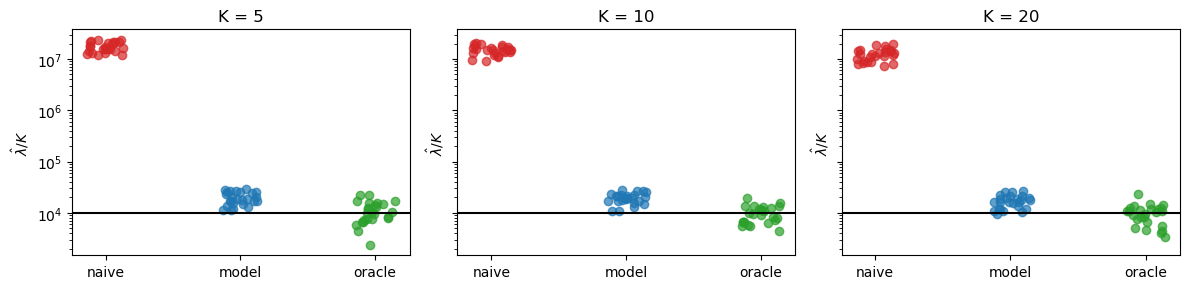

In [10]:
L = 25

Ks = [5, 10, 20]

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

In [84]:
K = 5
plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)

In [93]:
print('Oracle')
print(jnp.stack(plot_dict['oracle']).mean())
print(jnp.stack(plot_dict['oracle']).std())
print('')
print('Naive')
print(jnp.stack(plot_dict['naive']).mean())
print(jnp.stack(plot_dict['naive']).std())
print('')
print('Model')
print(jnp.stack(plot_dict['model']).mean())
print(jnp.stack(plot_dict['model']).std())

Oracle
51509.22
11271.678

Naive
63148784.0
9690095.0

Model
62219.973
15288.3125


In [81]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    mean = (jnp.stack(plot_dict['model'])/K).mean()
    std = (jnp.stack(plot_dict['model'])/K).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Model K=5
mean: 12014.20703125
std: 3255.215576171875
Model K=10
mean: 11585.013671875
std: 2440.78955078125
Model K=20
mean: 11527.02734375
std: 2062.32958984375


In [83]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    mean = (jnp.stack(plot_dict['oracle'])/K).mean()
    std = (jnp.stack(plot_dict['oracle'])/K).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Oracle K=5
mean: 10131.123046875
std: 2172.771240234375
Oracle K=10
mean: 9972.2509765625
std: 1916.6827392578125
Oracle K=20
mean: 9932.48828125
std: 2137.41455078125


In [12]:
L = 5
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    print((jnp.stack(plot_dict['model'])/K).mean())
    print((jnp.stack(plot_dict['model'])/K).std())

Model K=5
19644.443
5545.453
Model K=10
19656.277
4508.2715
Model K=20
17131.322
4915.058


In [97]:
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Naive K={K}')
    print((jnp.stack(plot_dict['naive'])/K).mean())
    print((jnp.stack(plot_dict['naive'])/K).std()) 

Naive K=5
12629757.0
1938019.0
Naive K=10
9800701.0
1734836.0
Naive K=20
8634182.0
1079170.8


In [98]:
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    print((jnp.stack(plot_dict['oracle'])/K).mean())
    print((jnp.stack(plot_dict['oracle'])/K).std()) 

Oracle K=5
10301.844
2254.3357
Oracle K=10
10178.751
2076.199
Oracle K=20
10301.524
1620.3984


In [11]:
def raw_xs_ns(cfg, seed, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']

    num_freqs = freqs.size
    zs = jnp.zeros((num_freqs, cfg.latent.K, cfg.latent.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    return xs, obs

(1000, 3, 25)
(1000, 10, 25)
(1000, 25, 25)


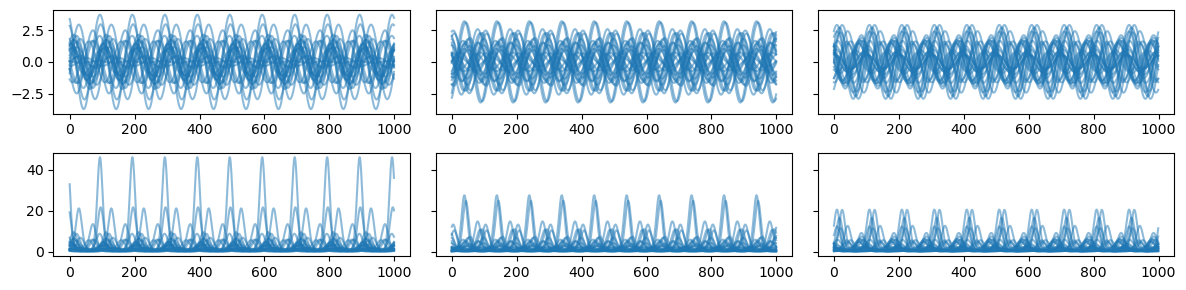

In [14]:
Ks = [3, 10, 25]
freqs = jnp.arange(500)
nz = jnp.array([cfg.latent.target_freq_ind])

fig, ax = plt.subplots(2, len(Ks), figsize=(12, 3), sharey='row')


L = 25
for i, K in enumerate(Ks):
    cfg = mod_config(cfg, K, L, mu)
    xs, obs = raw_xs_ns(cfg, 0)
    lams = jnp.exp(mu + xs)
    print(obs.shape)

    k = 0
    for l in range(L):
        ax[0,i].plot(xs[:,k,l], color='tab:blue', alpha=0.5)
    for l in range(L):
        ax[1,i].plot(lams[:,k,l], color='tab:blue', alpha=0.5)
plt.tight_layout()
    # data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    # category_labels = ['naive', 'oracle']

    # colors = ['tab:red', 'tab:green']
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15, colors=colors)
    # ax[i].axhline(plot_dict['true'][0]/K, color='k')
    # ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    # ax[i].set_title(f'K = {K}')
    # ax[i].set_yscale('log')

In [18]:
from hydra import initialize, compose
from hydra.core.config_store import ConfigStore
def omega(cfg):
    return OmegaConf.create(cfg)
# Create Gamma with new scaling
# How is Gamma created in script?
jax_boilerplate()

Platform:  cpu
28


In [19]:
# Create config - (incorporates overrides from from command line)
Config = get_sim_config()

with initialize(version_base=None, config_path="."):
    cfg = compose(
        config_name="config", 
        # overrides=["app.name=MyNewApp", "database.port=1234"]
    )
    # print(cfg)
    
lcfg = cfg.latent
ocfg = cfg.obs

latent_dir = conf.get_latent_dir(lcfg)
obs_dir = conf.get_obs_dir(ocfg, latent_dir)

lcfg.scale_power_target = 1e5

In [20]:
lrccn = create_lrccn_basic_rank1(lcfg)
lrk_sample_seed = lcfg.seed #+ lcfg.L
lrk_sample = jr.key(lrk_sample_seed)
zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
freqs = lrccn.freqs
nz = lrccn.nz
lcfg_resolved = OmegaConf.to_container(lcfg, resolve=True)
latent_save = {'lcfg': lcfg_resolved, 'zs_nz': zs_nz, 'nz': nz, 'freqs': freqs}
latent_savename = os.path.join(latent_dir, 'latent_sim.pkl')
pickle_save(latent_save, latent_savename) 
zs_existed = False

num_freqs = freqs.size
zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
zs = zs.at[nz,:,:].set(zs_nz)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

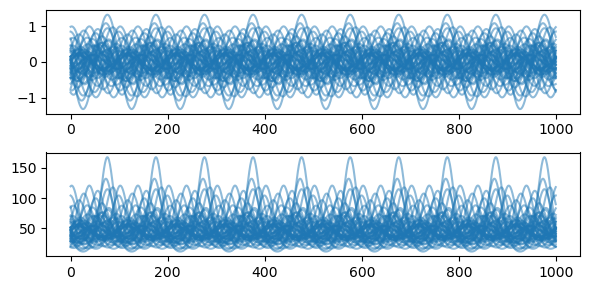

In [21]:
L = lcfg.L
k = 0
l = 0
mu = 3.8
lams = jnp.exp(mu + xs)
L_plot = L
fig, ax = plt.subplots(2,1,figsize=(6,3))
for l in range(L_plot):
    ax[0].plot(xs[:,k,l], color='tab:blue', alpha=0.5)
    ax[1].plot(lams[:,k,l], color='tab:blue', alpha=0.5)
plt.tight_layout()

In [22]:
def sample_func(scale, K, mu, seed):
    Config = get_sim_config()

    with initialize(version_base=None, config_path="."):
        cfg = compose(
            config_name="config", 
            # overrides=["app.name=MyNewApp", "database.port=1234"]
        )
        # print(cfg)
        
    lcfg = cfg.latent
    ocfg = cfg.obs
    lcfg.K = K

    lcfg.scale_power_target = scale

    lrccn = create_lrccn_basic_rank1(lcfg)
    lrk_sample_seed = seed
    lrk_sample = jr.key(lrk_sample_seed)
    zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
    freqs = lrccn.freqs
    nz = lrccn.nz

    num_freqs = freqs.size
    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs_params = ocfg
    ocfg.seed = seed
    ocfg.mu = mu
    obs = sample_obs(xs, obs_params)

    return zs_nz, xs, obs

In [23]:
def estimate_d1_func(zs_nz, obs, jind_nz=0, eigrank=1):
    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)
    nz_model = 9

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_oracle, eigval_naive

In [24]:
L = 50
scale = 1e6
K = 5
mu = 2.4
seed = 0

lred = 1

zt, xt, obst = sample_func(scale, K, mu, seed)
lamt = jnp.exp(mu+xt)
print(lamt.mean())

25.77884


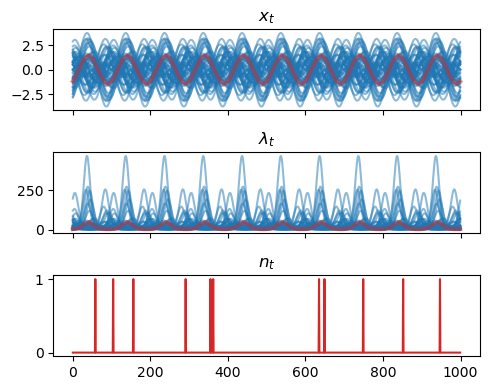

In [25]:
fig, ax = plt.subplots(3,1,figsize=(5,4), sharex=True)
for l in range(L):
    ax[0].plot(xt[:,0,l], color='tab:blue', alpha=0.5)
    ax[1].plot(lamt[:,0,l], color='tab:blue', alpha=0.5)
ax[0].plot(xt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
ax[0].set_title(r'$x_t$')
ax[1].plot(lamt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
ax[1].set_title(r'$\lambda_t$')
ax[2].plot(obst[:,0,lred], color='tab:red')
ax[2].set_title(r'$n_t$')
plt.tight_layout()

In [26]:
obst.mean()

Array(0.02566, dtype=float32)

In [27]:
# K = 3
# scale = 1e5
# mu = 2.5
# seed = 0

oracle_ests = []
naive_ests = []
for seed in [x for x in range(25)]:
    zt, xt, obst = sample_func(scale, K, mu, seed)
    oracle_est, naive_est = estimate_d1_func(zt, obst)
    oracle_ests.append(oracle_est)
    naive_ests.append(naive_est)




NameError: name 'nz_model' is not defined

Text(0.5, 1.0, 'K = 25')

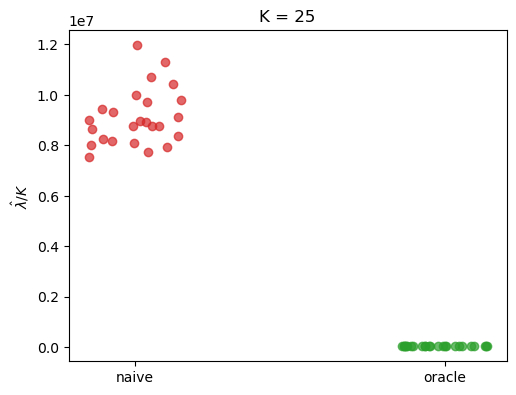

In [56]:
# Ks = [3, 10, 25]


# L = 5
# for i, K in enumerate(Ks):
#     plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
#     data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
# fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

# data = jnp.vstack([jnp.array(naive_ests), jnp.array(oracle_ests)]).swapaxes(0,1) / K
data = jnp.vstack([jnp.array(naive_ests), jnp.array(oracle_ests)]).swapaxes(0,1) / K

fig, ax = plt.subplots(figsize=(5,4))
category_labels = ['naive', 'oracle']
colors = ['tab:red', 'tab:green']
plot_sampling_dists(ax, data, category_labels, jitter=True, jitter_strength=0.15, colors=colors)
# ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'K = {K}')
# ax.set_yscale('log')

In [ ]:
# next - set up script to run with alternative scaling... run across K = 5 and 25
# check params from Emily 
# run larger scale
# check EM iter plots before r

# while running - work in eigvec plots / look at data options